#Importer les données :

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
import json

import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

import sys
import re, numpy as np, pandas as pd
from pprint import pprint

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

from gensim import models
from gensim.models import Phrases
from gensim import corpora
import numpy as np


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [39]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


In [51]:
pd.options.display.max_rows = 15

In [ ]:
pip install pyLDAvis

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [ ]:
read_json ='/content/drive/MyDrive/c2d3_newspapers.json'

In [ ]:
list0 = []
print("Started Reading JSON file which contains multiple JSON document")
with open(read_json, "r") as f:
    for jsonObj in f:
        data = json.loads(jsonObj)
        list0.append(data)
    print("Printing each JSON Decoded Object")





In [ ]:
import pandas as pd

df = pd.DataFrame(list0) 

In [ ]:
df.head()

#Préparation des données

In [ ]:
df1 = pd.DataFrame(columns=['@timestamp','feed','publication_timestamp','summary','text','title','type','url'])
for i in range(60000) :  
    df_new_row= pd.DataFrame(df['_source'][i],index=[i])
    df1 = df1.append(df_new_row, ignore_index=True)

In [ ]:
df2 = df[:60000]
df2

In [ ]:
df3 = df2.join(df1)

##Drop unnecessary columns

In [ ]:
#Drop unnecessary columns
ds = df3.drop(columns = ['_type','_index', '_score','type','_source'])

In [ ]:
ds.head()

## Topic modeling avec  60000 articles

### Pre processing

In [ ]:
!python -m spacy download fr_core_news_md

In [ ]:
import fr_core_news_md

nlp = fr_core_news_md.load()

#Tokenisation

In [18]:
# on tokenize le text
ds["text_word_token"] = ds["text"].map(lambda x : word_tokenize(x.replace("'", " ")))# on remplace les appostrophes par un espaces
# car la tokenization avec la fonction "word_tokenize" de nltk ne les sépare pas autrement 
ds["text_word_token"] = ds["text_word_token"].map(lambda list_word: [word.lower()  for word in list_word if word.isalpha()])

# on tokenize le résumé
ds["summary_word_token"] = ds["summary"].map(lambda x : word_tokenize(x.replace("'", " ")))
ds["summary_word_token"] = ds["summary_word_token"].map(lambda list_word: [word.lower()  for word in list_word if word.isalpha()])

#Supprimer les stopwords

In [19]:
# création de la liste de stopwords
custom_stopwords = ["a", "dont", "madame", "monsieur", "peut", "dès", "lors", "être", "ce",
                    "ces", "cet", "cette", "comme", "ainsi", "si","et","le", "la","l","deux","troix","aussi","tous","tout","plus","ça","selon", 
                    "fait" ,"après" ,"encore" ,"leurs" ,"entre", "également" ,"depuis", "elles" ,"alors","faire","bien",
                    "très","faire","ans", "année","cela", "sans", "où","autres","h", "notamment"]
stopwords_fr = stopwords.words('french') + custom_stopwords
print(len(stopwords_fr))
#print(stopwords_fr)

# on enlève les stopwords
ds["text_word_token"] = ds["text_word_token"].map(lambda list_word: [word for word in list_word if word not in stopwords_fr])

205


#Lemmatization
Garder que les Racines des mots

In [20]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [21]:
ds["text_word_token0"] = lemmatization(ds["text_word_token"], allowed_postags=['NOUN', 'ADJ'])

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:13

##Creating Bigram and Trigram Models
Dans l'étape ci-dessous, nous allons, à partir de notre liste de tokens nettoyés, créer des bigrammes. Les bigrammes sont des paires de mots, qui peuvent être porteurs de sens et qui sont donc utile pour le topic extraction.

In [22]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(ds["text_word_token0"], min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[ds["text_word_token0"]], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[ds["text_word_token0"][0]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['homme', 'femme', 'assassinat', 'homme', 'femme', 'marie', 'victime', 'épouse', 'sophie', 'ami', 'premier', 'couple', 'cour', 'hérault', 'montpellier', 'mardi', 'mars', 'jusqu', 'vendredi', 'mars', 'accusé', 'crim', 'complicité_assassinat', 'femme', 'bueno', 'appel', 'témoin', 'octobre', 'enquêteur', 'gendarmerie', 'appel', 'témoin', 'média', 'bueno', 'juillet', 'compagnon', 'marie', 'brigade', 'juillet', 'gendarme', 'recherche', 'partie', 'course', 'fille', 'relation', 'conflictuel', 'difficile', 'point', 'enfant', 'famill', 'accueil', 'séparer', 'mère', 'premier', 'temps', 'gendarme', 'suicide', 'départ', 'volontaire', 'départ', 'cas', 'suicide', 'dépouill', 'mois', 'décembr', 'procureur', 'information', 'judiciaire', 'disparition_inquiétant', 'déclaration', 'compagnon', 'incohérence', 'date', 'disparition', 'avance', 'militaire', 'audition', 'compagnon', 'coupl', 'ami', 'concubin', 'gard', 'fille', 'défunt', 'gendarme', 'mère', 'version', 'fait', 'détention_provisoire', 'mise', 'ex

In [23]:
data_words = ds["text_word_token0"]

In [24]:
ds["text_word_token0"][0][20:60]

['accusé',
 'crim',
 'complicité',
 'assassinat',
 'femme',
 'bueno',
 'appel',
 'témoin',
 'octobre',
 'enquêteur',
 'gendarmerie',
 'appel',
 'témoin',
 'média',
 'bueno',
 'juillet',
 'compagnon',
 'marie',
 'brigade',
 'juillet',
 'gendarme',
 'recherche',
 'partie',
 'course',
 'fille',
 'relation',
 'conflictuel',
 'difficile',
 'point',
 'enfant',
 'famill',
 'accueil',
 'séparer',
 'mère',
 'premier',
 'temps',
 'gendarme',
 'suicide',
 'départ',
 'volontaire']

#Remove articles that are too short (Not important)
To optimize the topic model results, we can avoid to have articles with less then 30 tokens after cleaning



In [25]:
ds = ds[ds["text_word_token0"].map(len) >= 30]

#make sure all tokenized items are lists

ds = ds[ds["text_word_token0"].map(type) == list]

ds.reset_index(drop=True,inplace=True)

print("After cleaning and excluding short aticles, the dataframe now has:", len(ds), "articles")

After cleaning and excluding short aticles, the dataframe now has: 41146 articles


In [33]:
ds1 = ds.drop(columns = ['summary', 'text'])

In [36]:
ds1.to_csv(r'C:\Users\telbermaki\Desktop\articles 60000.csv', index = False)

# Modèle LDA (Latent Dirichlet Allocation)

LDA est un algorithme d'extraction de topics. A partir d'un corpus de documents, il permet de : 
- définir un nombre de topics (un topic est caractérisé par une liste de mots)
- attribuer à chaque document un ou des topics de la liste de topics trouvés par l'algorithme 

In [26]:
data_words = ds['text_word_token0']

In [27]:
print (data_words[0][0:20])

['homme', 'femme', 'assassinat', 'homme', 'femme', 'marie', 'victime', 'épouse', 'sophie', 'ami', 'premier', 'couple', 'cour', 'hérault', 'montpellier', 'mardi', 'mars', 'jusqu', 'vendredi', 'mars']


In [28]:
id2word = corpora.Dictionary(data_words)

corpus = []
for text in data_words:
    new = id2word.doc2bow(text)
    corpus.append(new)

print (corpus[0][0:20])

word = id2word[[0][:1][0]]
print (word)

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 3), (5, 1), (6, 1), (7, 2), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 3), (16, 1), (17, 1), (18, 5), (19, 1)]
accueil


Cela commence par passer en revue chaque mot de chaque document et définir un numéro de sujet aléatoire en fonction du nombre de sujets k entrés dans le modèle.
Ensuite, à la deuxième itération, il calcule la probabilité qu'un mot M soit dans le sujet t en se basant sur :
- les sujets qui sont dans le document
- les fois qu'un mot w a été assigné à un sujet t
Il continue d'itérer jusqu'à ce que la sortie souhaitée soit atteinte.

In [42]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

#α et β
Quelques hyper-paramètres qui peuvent être réglés dans un modèle LDA

α : contrôle la distribution des sujets par document

β : contrôle la distribution des mots par sujet

Une valeur élevée pour α signifie qu'un document a très probablement une variété de sujets et n'est pas limité à quelques sujets et vice versa.
Alors qu'une valeur élevée pour β indique qu'une distribution de sujets inclurait une variété de mots et qu'une valeur faible indique qu'un sujet inclurait moins de mots

Et cela signifie qu'étant donné une valeur α élevée, plus de documents seraient classés comme étant similaires les uns aux autres, car un plus grand nombre d'entre eux auraient une distribution de sujets similaire en raison du nombre élevé de sujets.
Et une valeur β élevée signifie que les sujets semblent plus similaires.
La définition des valeurs de α et β dépend largement du cas d'utilisation.

##Coherence et Perplexity

In [43]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.339499039973939

Coherence Score:  0.46025888461790393


#Optimisation du nombres de topics


In [ ]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
#mallet_path = 'path/to/mallet-2.0.8/bin/mallet' # update this path
#ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [ ]:
# Show Topics
#pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
#coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_words, dictionary=id2word, coherence='c_v')
#coherence_ldamallet = coherence_model_ldamallet.get_coherence()
#print('\nCoherence Score: ', coherence_ldamallet)

In [40]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

#Vizualizing the Data

In [44]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.193789  0.072054       1        1  14.126619
14    -0.383610  0.073555       2        1  12.245539
...         ...       ...     ...      ...        ...
2      0.365623  0.046526      14        1   2.961612
11     0.371434  0.258549      15        1   2.310278

[15 rows x 5 columns], topic_info=           Term          Freq         Total Category  logprob  loglift
1940   appareil  65374.000000  65374.000000  Default  30.0000  30.0000
18794    cookie  45735.000000  45735.000000  Default  29.0000  29.0000
...         ...           ...           ...      ...      ...      ...
263        site    965.955585   6320.366667  Topic15  -4.5175   1.8894
389     mondial    725.279520   3031.917752  Topic15  -4.8041   2.3374

[778 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1486      8  0.999922  acceptation
656      10  0.994840     accident
...     ...       ...          ...
2999      2  0.113741         zone
2999      5  0.100051         zone

[1279 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 15, 14, 10, 9, 7, 8, 2, 5, 1, 11, 6, 13, 3, 12])

Texte de l'article numéro 40000
Ce 14 fevrier, une collision entre un train et une voiture a eu lieu sur la commune de Saint-Cergues en Haute-Savoie. Un homme de 70 ans, le conducteur, est decede. 71 personnes, qui etaient a bord du train, sont en cours devacuation.

La collision a eu lieu en fin dapres-midi sur la commune de Saint-Cergues en Haute-Savoie, au passage a niveau numero 55.

Un train a percute une voiture, son automobiliste, age denviron 70 ans, est decede.

71 personnes en cours devacuation

71 personnes, qui etaient a bord du train, sont actuellement evacuees par les secours et la gendarmerie ainsi que les services de la SNCF.

L'un des passagers et le conducteur, choques, ont ete pris en charge par les secours.

Une quinzaine de sapeurs-pompiers est sur les lieux.


Topics et probilités associées


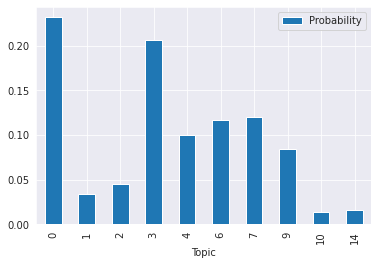

In [46]:
numero_doc = 40000


print("Texte de l'article numéro {}".format(numero_doc))
print(ds.loc[numero_doc, "text"])
print("\n")
print("Topics et probilités associées")
proba = pd.DataFrame(lda_model[corpus[numero_doc]], columns=['Topic', 'Probability'])
proba.plot(kind='bar', x='Topic')

In [47]:
ds["topic_list"] = [lda_model[i] for i in corpus]
# la commande ci dessus nous permet, pour chaque document, d'obtenir une liste de topics avec les probabilités associées 
# que chaque document appartienne 
def topic_majoritaire(list_topic, is_proba): 
    proba = [x[1] for x in list_topic]
    max_index = proba.index(max(proba))
    return list_topic[max_index][is_proba]
ds["main_topic"] = ds["topic_list"].map(lambda list_topic: topic_majoritaire(list_topic, 0))
ds["main_topic_proba"] = ds["topic_list"].map(lambda list_topic: topic_majoritaire(list_topic, 1))

In [52]:
ds["nombre_documents"] = 1
ds_topic = ds.groupby(["main_topic"])["nombre_documents"].count().sort_values(ascending = False).reset_index()
ds_topic

,main_topic,nombre_documents
0,14,5655
1,13,5632
2,3,5537
3,0,4556
4,9,4540
5,6,4009
6,8,3117
7,1,2485
8,7,2090
9,4,1498


In [54]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Topic_dominant', 'Pourcentage_contribution', 'Mots_clés_topic']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel= lda_model, corpus=corpus, texts=data_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Topic_dominant', 'Pourcentage_contribution', 'Mots_clés_topic', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Topic_dominant,Pourcentage_contribution,Mots_clés_topic,Text
0,0,6.0,0.5435,"homme, victime, mort, jeune, explosion, nuit, ...","[homme, femme, assassinat, homme, femme, marie..."
1,1,13.0,0.3488,"premier, match, jeu, equipe, point, bon, face,...","[premier, report, oursinad, sèt, place, rue, v..."
2,2,1.0,0.5480,"acceptation, vie, petit, enfant, jeune, femme,...","[hui, nuit, molière, théâtre, molièr, avenue, ..."
3,3,6.0,0.4266,"homme, victime, mort, jeune, explosion, nuit, ...","[gendarme, contravention, vendredi, mars, soir..."
4,4,13.0,0.4894,"premier, match, jeu, equipe, point, bon, face,...","[mardi, mars, cinquième, ambre, parti, cinquiè..."
5,5,9.0,0.2087,"tre, heure, lieu, dune, libre, mars, salle, sa...","[russe, banni, nombreux, champion, appel, sema..."
6,6,3.0,0.3711,"mois, dernier, jour, nouveau, situation, premi...","[élu, création, règlement, municipal, lundi, m..."
7,7,14.0,0.2692,"espac, projet, travail, nouveau, local, jeune,...","[coureur, réseau, social, distance, long, cell..."
8,8,13.0,0.5266,"premier, match, jeu, equipe, point, bon, face,...","[météo, édition, historique, participation, pl..."
9,9,13.0,0.2638,"premier, match, jeu, equipe, point, bon, face,...","[édition, festival, vif, magie, étape, montpel..."


In [57]:
df_dominant_topic.tail(10)

,Document_No,Topic_dominant,Pourcentage_contribution,Mots_clés_topic,Text
41136,41136,9.0,0.2595,"tre, heure, lieu, dune, libre, mars, salle, sa...","[collectif, printemps, discrimination, racism,..."
41137,41137,13.0,0.3273,"premier, match, jeu, equipe, point, bon, face,...","[tennis, fort, progression, resultat, positif,..."
41138,41138,2.0,0.3567,"classe, enfant, scolaire, parent, eleve, secou...","[lundi, fevrier, parent, grand, jardin, effet,..."
41139,41139,9.0,0.4909,"tre, heure, lieu, dune, libre, mars, salle, sa...","[jour, sinscrir, repas, choucrout, musical, ai..."
41140,41140,9.0,0.2124,"tre, heure, lieu, dune, libre, mars, salle, sa...","[danse, plaisir, ferveur, communicatif, cest, ..."
41141,41141,13.0,0.4362,"premier, match, jeu, equipe, point, bon, face,...","[senior, fille, surprise, victoire, dune, tre,..."
41142,41142,7.0,0.2458,"fevrier, ete, cest, dun, lassociation, annee, ...","[fete, date, amoureux, releve, tradition, lhis..."
41143,41143,7.0,0.2683,"fevrier, ete, cest, dun, lassociation, annee, ...","[document, actuel, obsolet, vote, ete, ete, re..."
41144,41144,7.0,0.2879,"fevrier, ete, cest, dun, lassociation, annee, ...","[beau, succe, vendredi, fevrier, cadre, manife..."
41145,41145,7.0,0.2795,"fevrier, ete, cest, dun, lassociation, annee, ...","[dimanche, fevrier, lassociation, jeune, vestr..."


In [59]:
df_dominant_topic.to_csv(r'df_dominant_topic.csv', index = False)

In [55]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Topic_dominant'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Topic_dominant', 'Mots_clés_topic']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Topic_dominant', 'Mots_clés_topic', 'Num_Documents', 'Pourcentage_contribution']

# Show
df_dominant_topics

,Topic_dominant,Mots_clés_topic,Num_Documents,Pourcentage_contribution
0.0,6.0,"homme, victime, mort, jeune, explosion, nuit, ...",4556.0,0.1107
1.0,13.0,"premier, match, jeu, equipe, point, bon, face,...",2485.0,0.0604
2.0,1.0,"acceptation, vie, petit, enfant, jeune, femme,...",753.0,0.0183
3.0,6.0,"homme, victime, mort, jeune, explosion, nuit, ...",5538.0,0.1346
4.0,13.0,"premier, match, jeu, equipe, point, bon, face,...",1499.0,0.0364
...,...,...,...,...
41141.0,13.0,"premier, match, jeu, equipe, point, bon, face,...",NaN,NaN
41142.0,7.0,"fevrier, ete, cest, dun, lassociation, annee, ...",NaN,NaN
41143.0,7.0,"fevrier, ete, cest, dun, lassociation, annee, ...",NaN,NaN
41144.0,7.0,"fevrier, ete, cest, dun, lassociation, annee, ...",NaN,NaN


#Other visualisation

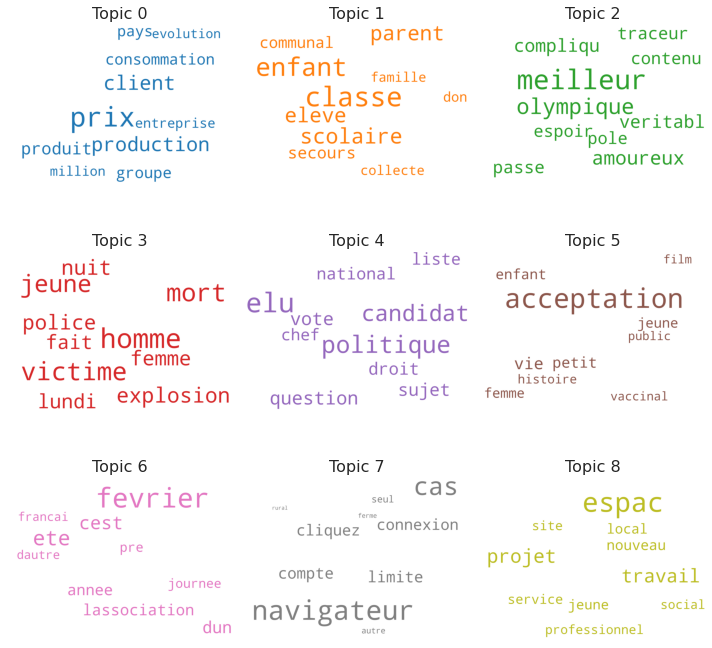

In [53]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords= stopwords_fr,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()